<a href="https://colab.research.google.com/github/ValentinVignal/HDStyleTransfert/blob/google-colab/style_transfert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HD Style transfert

## Utilisation

1. Create 1 folders on your computer names *content* and *style*
2. Put the corresponding images in it
3. Creat 2 `.zip` files: `content.zip` and `style.zip`
4. Import them in the session (column on the left)
5. Run everything

## What it does

It does all the combinaison of the content and style files and do the style transfert. It saves everything in the folder *results* with the architecture:
```bash
results/
 |- content_image_name1/
 |  |- style_image_name1/
 |  |  |- n_step.png          # The style transfered image at the step n
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- content_image_name2/
 |  |- style_image_name1/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- ...

```

## To keep the environment connected

1. Press `Ctrl` + ` Shift` + `i`
2. Go to *Console*
3. Paste these lines:
  ```javascript
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
  }
  setInterval(ClickConnect,60000);
  ```
4. Press `Enter`

## To allow the download

You need to enable third-party cookies but for now it only works for Chrome browser, open
```
chrome://settings/content/cookies
```
make sure the option for Block third-party cookies is disabled and click add button in Allow section then add
```
colab.research.google.com
```

# Parameters

You can customize the parameters by changing the value in the following dictionaries (the `None` value is considered as the default value).

Check out the default values in [this folder](https://github.com/ValentinVignal/HDStyleTransfert/tree/master/src/variables).

In [0]:
# Global Variables
global_variables = {
  "img_size_nn": None,   # Max size of the input of the nn
  "img_size_hd": None,   # Max size of the generated image
  "nb_offsets": None     # Number of offsets to do overlapping
}

In [0]:
# Parameters
parameters = {
  "style_weight": None,    # Importance of style
  "content_weight": None,    # Importance of content
  "total_variation_weight" : None,   # How much to reduce high frequencies
  "ration_weight": None,    # Exponential reduction of the small sub-images
  "epochs": None,   # Number of epochs
  "steps_per_epoch": None,    # Number of steps per epoch
  "lr": None,    # Learning rate
  "style_division": None,    # Divide the style image like the content image ?
  "content_layers": None,   # List of names of the content layers
  "style_layers": None,   # List of names of the style layers
  "image_start": ['content', 'style', 'grey']   # Options for the start image
}

# Setup

In [3]:
# Install tensorflow
try:
  # %tensroflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.test.gpu_device_name())
print('tf version', tf.__version__)

/device:GPU:0
tf version 2.2.0


In [4]:
# Clone the github repo
!git init
!git clone https://github.com/ValentinVignal/HDStyleTransfert.git
# Go in it
%cd HDStyleTransfert/

Initialized empty Git repository in /content/.git/
Cloning into 'HDStyleTransfert'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 214 (delta 119), reused 97 (delta 44), pack-reused 0
Receiving objects: 100% (214/214), 6.07 MiB | 8.95 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/HDStyleTransfert


In [5]:
# Install dependencies except tensorflow
%pip install $(grep -ivE "tensorflow|Pillow|ipython" requirements.txt)

In [0]:
%matplotlib inline

In [0]:
from epicpath import EPath
import json

# Save the variables files
global_variables_path = EPath('global_variables.json')
parameters_path = EPath('parameters.json')
with open(global_variables_path, 'w') as json_file:
  json.dump(global_variables, json_file)
with open(parameters_path, 'w') as json_file:
  json.dump(parameters, json_file)

In [0]:
# !rm -r results
# !git pull

# Run

In [0]:
all_images = True     # To do all the combinaisons of the images

196608/195196 [==============================] - 0s 0us/step
3 combinations (1 contents, 1 styles, 3 starts)
Combination 0/3 (  0%) [>                                                 ] ETA -:--:--
80142336/80134624 [==============================] - 1s 0us/step


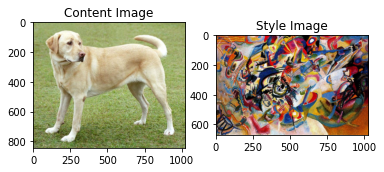

Epoch 0/5 (  0%) [.                   ]
Step 5/5 (100%) [....................] Time 0:01:06


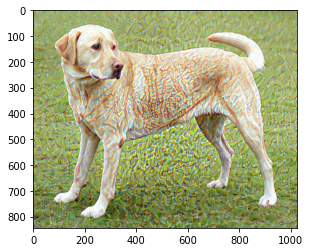

Epoch 1/5 ( 20%) [.....               ]
Step 10/10 (100%) [....................] Time 0:00:38


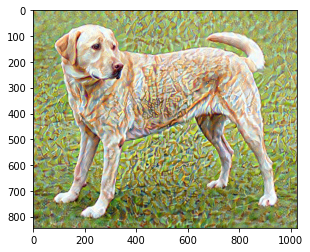

Epoch 2/5 ( 40%) [.........           ]
Step 15/15 (100%) [....................] Time 0:00:58


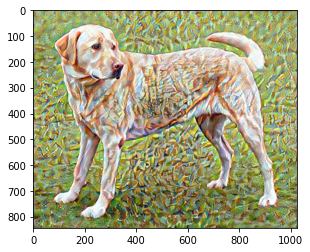

Epoch 3/5 ( 60%) [.............       ]
Step 20/20 (100%) [....................] Time 0:01:17


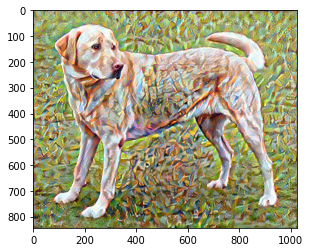

Epoch 4/5 ( 80%) [.................   ]
Step 14/25 ( 56%) [............        ] ETA 0:00:42

In [0]:
import os
import src
from loadbar import RainbowBar
import IPython.display as display

content_path_list, style_path_list = src.data.get_data()
num_content = len(content_path_list)
num_style = len(style_path_list)
num_image_start = src.var.p.num_image_start
nb_combinations = num_content * num_style * src.var.p.num_image_start
print(f'{nb_combinations} combinations ({num_content} contents, {num_style} styles, {num_image_start} starts)')
bar = RainbowBar( max=nb_combinations, size=50, head='>', body='-', title='Combination')
bar.start()
for i in range(num_content * num_style):
  if i > 0: display.clear_output(wait=True)
  # I launch a different process to solve the leak memory issue in tensorflow.
  # When the process is finished, at least everything about this one is cleaned and I can start again peacefully
  # and there is no memory issue anymore :)
  bar.update(step=i, end='\n')
  %run style_transfert.py
  if not all_images:
    # Do only one image
    break
bar.end()

# Save and download

In [0]:
# Zip it
!zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/YellowLabradorLooking_new/ (stored 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/ (stored 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_7.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_385.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_105.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_147.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_70.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_42.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_315.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_21.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_196.png (deflated 0%)
  adding: results/YellowLabradorLooking_new/kandinsky5/step_252.png (deflated 0%)


In [0]:
# Download it
from google.colab import files


is_downloaded = False
i = 0
while not is_downloaded:
  try:
    files.download('results.zip')
    is_downloaded = True
  except Exception as e:
    i += 1
    print(i, e)
  if i == 100:
    print('Could not download')
    break

# If this part doesn't work, see the section "To allow the download" at the beginning

End :)